In [1]:
import pandas as pd
import numpy as np
import faiss
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Load Datasets

In [3]:
train_df=pd.read_csv("C:/Users/SHARON/Downloads/Train (2).csv")
test_df=pd.read_csv("C:/Users/SHARON/Downloads/Test (2).csv")
toilet_df=pd.read_csv("C:/Users/SHARON/Downloads/toilets.csv")
waste_df=pd.read_csv("C:/Users/SHARON/Downloads/waste_management.csv")
water_df=pd.read_csv("C:/Users/SHARON/Downloads/water_sources.csv")

In [4]:
train_df.head()

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267
2,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
3,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267
4,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267


In [5]:
if 'Total' not in train_df.columns:
    print("Error: 'Total' column is missing from train_df")
else:
    print("The 'Total' column exists in train_df")

# Ensure 'Total' is part of both train and test datasets before concatenation
# If missing, we can add a placeholder for test_df (NaN or 0s depending on your needs)
if 'Total' not in test_df.columns:
    test_df['Total'] = None 

The 'Total' column exists in train_df


In [6]:

# Rearrange columns in test_df to match train_df
test_df = test_df[train_df.columns]
# Merge datasets on shared keys: 'Year', 'Month', 'Transformed_Latitude', and 'Transformed_Longitude'
hospital_df = pd.concat([train_df, test_df], ignore_index=True)

In [7]:
# Drop unnecessary columns from supplementary datasets
for df in [toilet_df, waste_df, water_df]:
    df.drop(columns=['Year', 'Month'], inplace=True)

In [8]:
# Rename columns for clarity
def rename_columns(df, prefix):
    for col in df.columns:
        if col not in ['Month_Year_lat_lon', 'lat_lon']:
            df.rename(columns={col: f"{prefix}_{col}"}, inplace=True)

rename_columns(toilet_df, "toilet")
rename_columns(waste_df, "waste")
rename_columns(water_df, "water")


In [9]:
# Fill missing values in the 'Total' column
hospital_df['Total'].fillna(0, inplace=True)


In [10]:
hospital_df.isnull().sum()

ID                               0
Total                            0
Location                         0
Category_Health_Facility_UUID    0
Disease                          0
Month                            0
Year                             0
Transformed_Latitude             0
Transformed_Longitude            0
dtype: int64

In [11]:
# Drop rows with missing latitude and longitude in water sources
water_df.dropna(subset=['water_Transformed_Latitude'], inplace=True)

In [12]:
def plot_locations(year=2022, month=1, month_name='January'):
    if year < 2019 or year > 2023:
        print("Invalid year. Please choose a year between 2019 and 2023.")
        return

    if month < 1 or month > 12:
        print("Invalid month. Please choose a month between 1 and 12.")
        return

    if month_name.capitalize() not in ['January', 'February', 'March',
                                       'April', 'May', 'June', 'July',
                                       'August', 'September', 'October',
                                       'November', 'December']:
        print("Invalid month name. Please choose from 'January' to 'December'.")
        return

    plt.figure(figsize=(10, 6))
    subsets = [
        (hospital_df.query(f"Year == {year} and Month == {month}"), 'Transformed', 'Hospital', 's'),
        (water_df.query(f"water_Month_Year == '{month}_{year}'"), 'water_Transformed', 'Water', 'o'),
        (waste_df.query(f"waste_Month_Year == '{month}_{year}'"), 'waste_Transformed', 'Waste', 'x'),
        (toilet_df.query(f"toilet_Month_Year == '{month}_{year}'"), 'toilet_Transformed', 'Toilet', '^'),
    ]
    for df, prefix, label, marker in subsets:
        plt.scatter(df[f'{prefix}_Longitude'], df[f'{prefix}_Latitude'], label=label, alpha=0.8, marker=marker)
    plt.title(f'Locations ({month_name.capitalize()} {year})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(True)
    plt.show()

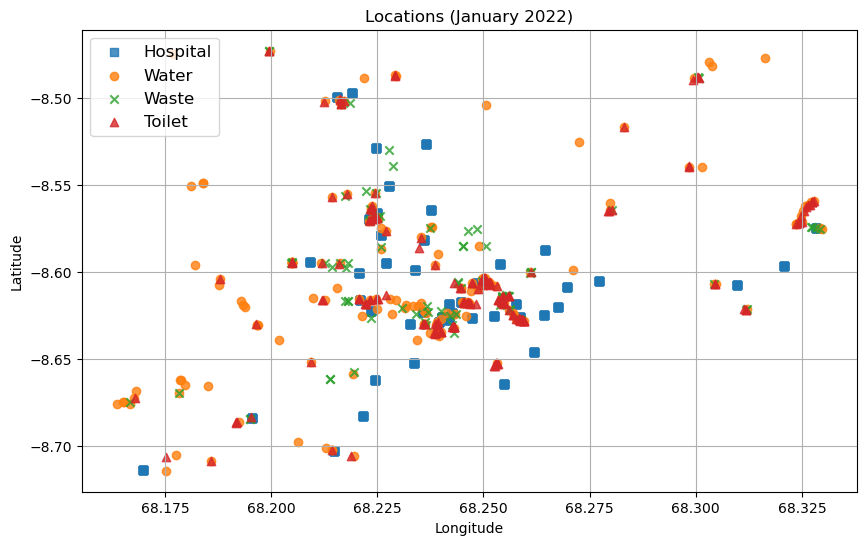

In [13]:
plot_locations()

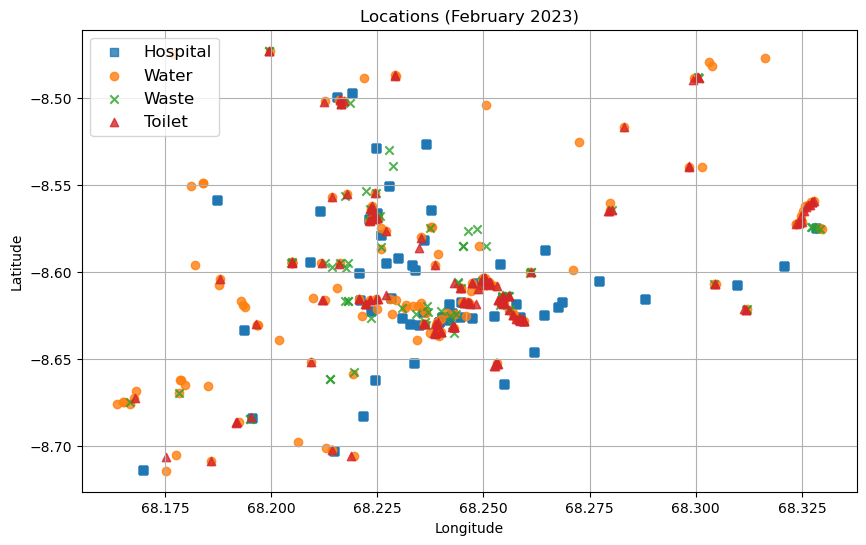

In [14]:
plot_locations(year=2023, month=2, month_name='February')

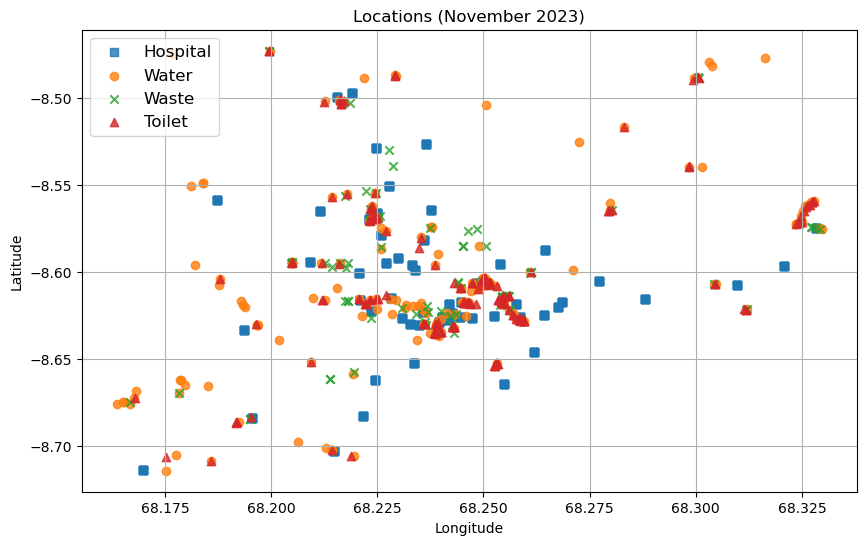

In [15]:
plot_locations(year=2023, month=2, month_name='November')

In [16]:
def find_nearest(hospital_df, location_df, lat_col, lon_col, id_col):
    # Prepare the data for faiss
    location_data = location_df[[lat_col, lon_col]].values.astype(np.float32)
    
    # Create a faiss index
    index = faiss.IndexFlatL2(location_data.shape[1])  # L2 distance (Euclidean distance)
    index.add(location_data)  # Add location data to the index
    
    nearest = {}
    
    # Loop through each hospital and find the nearest site in location_df
    for _, row in hospital_df.iterrows():
        query_location = np.array([row['Transformed_Latitude'], row['Transformed_Longitude']], dtype=np.float32).reshape(1, -1)
        _, idx = index.search(query_location, 1)  # Search for the nearest neighbor
        nearest[row['ID']] = location_df.iloc[idx[0][0]][id_col]
    
    return nearest

In [17]:
# Ensure unique identifier columns exist in all supplementary datasets
for df, prefix in [(toilet_df, 'toilet'), (waste_df, 'waste'), (water_df, 'water')]:
    df[f"{prefix}_Month_Year_lat_lon"] = (
        df[f"{prefix}_Month_Year"] + '_' +
        df[f"{prefix}_Transformed_Latitude"].astype(str) + '_' +
        df[f"{prefix}_Transformed_Longitude"].astype(str)
    )

In [18]:
toilet_df.head()

,toilet_10u,toilet_10v,toilet_2d,toilet_2t,toilet_evabs,toilet_evaow,toilet_evatc,toilet_evavt,toilet_albedo,toilet_lshf,...,toilet_swvl1,toilet_swvl2,toilet_swvl3,toilet_swvl4,toilet_Transformed_Latitude,toilet_Transformed_Longitude,toilet_Month_Year,lat_lon,Month_Year_lat_lon,toilet_Month_Year_lat_lon
0,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,0.173221,0.650001,...,0.346542,0.335724,0.264359,0.300018,-8.61768,68.24536,1_2019,-8.61768_68.24536,1_2019_-8.61768_68.24536,1_2019_-8.61768_68.24536
1,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,0.173808,0.650001,...,0.254517,0.259918,0.281769,0.296188,-8.61768,68.24536,2_2019,-8.61768_68.24536,2_2019_-8.61768_68.24536,2_2019_-8.61768_68.24536
2,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,0.178823,0.650001,...,0.278152,0.284195,0.261597,0.291672,-8.61768,68.24536,3_2019,-8.61768_68.24536,3_2019_-8.61768_68.24536,3_2019_-8.61768_68.24536
3,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,0.180959,0.650017,...,0.385513,0.378616,0.309784,0.288925,-8.61768,68.24536,4_2019,-8.61768_68.24536,4_2019_-8.61768_68.24536,4_2019_-8.61768_68.24536
4,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,0.182375,0.650009,...,0.397659,0.400055,0.392654,0.309311,-8.61768,68.24536,5_2019,-8.61768_68.24536,5_2019_-8.61768_68.24536,5_2019_-8.61768_68.24536


In [19]:
merged_data = hospital_df.copy()
datasets = [
    (toilet_df, 'toilet', 'toilet_Month_Year_lat_lon'),
    (waste_df, 'waste', 'waste_Month_Year_lat_lon'),
    (water_df, 'water', 'water_Month_Year_lat_lon'),
]

In [20]:
for df, prefix, id_col in datasets:
    nearest = find_nearest(merged_data, df, f"{prefix}_Transformed_Latitude", f"{prefix}_Transformed_Longitude", id_col)
    nearest_df = pd.DataFrame(list(nearest.items()), columns=['ID', id_col])
    merged_data = merged_data.merge(nearest_df, on="ID").merge(df, on=id_col)

In [21]:
merged_data.shape

(29332, 135)

In [22]:
merged_data.head(2)

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,toilet_Month_Year_lat_lon,...,water_tp,water_swvl1,water_swvl2,water_swvl3,water_swvl4,water_Transformed_Latitude,water_Transformed_Longitude,water_Month_Year,lat_lon,Month_Year_lat_lon
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267,1_2019_-8.62979_68.23582,...,0.006655,0.346542,0.335724,0.264359,0.300018,-8.62966,68.23589,1_2019,-8.62966_68.23589,1_2019_-8.62966_68.23589
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267,1_2019_-8.62979_68.23582,...,0.006655,0.346542,0.335724,0.264359,0.300018,-8.62966,68.23589,1_2019,-8.62966_68.23589,1_2019_-8.62966_68.23589


In [23]:
merged_data.isnull().sum()

ID                               0
Total                            0
Location                         0
Category_Health_Facility_UUID    0
Disease                          0
                                ..
water_Transformed_Latitude       0
water_Transformed_Longitude      0
water_Month_Year                 0
lat_lon                          0
Month_Year_lat_lon               0
Length: 135, dtype: int64

In [24]:
merged_data.duplicated().sum()

7288

In [25]:
merged_data.drop_duplicates(inplace=True)

In [26]:
merged_data.duplicated().sum()

0

In [27]:
non_numeric_cols = merged_data.select_dtypes(exclude=['number']).columns.tolist()

# Display non-numeric columns
print("Non-numeric columns in the dataset:", non_numeric_cols)

Non-numeric columns in the dataset: ['ID', 'Location', 'Category_Health_Facility_UUID', 'Disease', 'toilet_Month_Year_lat_lon', 'toilet_Month_Year', 'lat_lon_x', 'Month_Year_lat_lon_x', 'waste_Month_Year_lat_lon', 'waste_Month_Year', 'lat_lon_y', 'Month_Year_lat_lon_y', 'water_Month_Year_lat_lon', 'water_Month_Year', 'lat_lon', 'Month_Year_lat_lon']


In [28]:
le = LabelEncoder()

# List of columns to encode
columns_to_encode = ['ID', 'Location', 'Category_Health_Facility_UUID', 'Disease', 'toilet_Month_Year_lat_lon', 'toilet_Month_Year', 'lat_lon_x', 'Month_Year_lat_lon_x', 'waste_Month_Year_lat_lon', 'waste_Month_Year', 'lat_lon_y', 'Month_Year_lat_lon_y', 'water_Month_Year_lat_lon', 'water_Month_Year', 'lat_lon', 'Month_Year_lat_lon']

# Encode the specified columns in the merged data
for column in columns_to_encode:
    merged_data[column] = le.fit_transform(merged_data[column])

# Check the results after encoding
merged_data.head()

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,toilet_Month_Year_lat_lon,...,water_tp,water_swvl1,water_swvl2,water_swvl3,water_swvl4,water_Transformed_Latitude,water_Transformed_Longitude,water_Month_Year,lat_lon,Month_Year_lat_lon
0,5151,0.0,17,168,2,12,2022,-8.62982,68.23267,28,...,0.006655,0.346542,0.335724,0.264359,0.300018,-8.62966,68.23589,0,35,35
1,5155,0.0,17,168,6,12,2022,-8.62982,68.23267,28,...,0.006655,0.346542,0.335724,0.264359,0.300018,-8.62966,68.23589,0,35,35
2,5150,0.0,17,168,1,12,2022,-8.62982,68.23267,28,...,0.006655,0.346542,0.335724,0.264359,0.300018,-8.62966,68.23589,0,35,35
5,5154,0.0,17,168,5,12,2022,-8.62982,68.23267,28,...,0.006655,0.346542,0.335724,0.264359,0.300018,-8.62966,68.23589,0,35,35
6,5153,6.0,17,168,4,12,2022,-8.62982,68.23267,28,...,0.006655,0.346542,0.335724,0.264359,0.300018,-8.62966,68.23589,0,35,35


In [29]:
X = merged_data.drop(columns=['Total'], axis=1)  # Drop target and non-predictive columns
y = merged_data['Total']
X_test = merged_data.drop(columns=['Total'], axis=1)

In [30]:

# Initialize the base model (Level-0) - RandomForestRegressor
base_model = RandomForestRegressor(
    n_estimators=100, random_state=100)


# Initialize the meta-model (Level-1) - GradientBoostingRegressor
meta_model = GradientBoostingRegressor(n_estimators=100, random_state=100)

# Initialize the Stacking Regressor
stacking_model = StackingRegressor(
    estimators=[('rf', base_model)],  # Base model(s)
    final_estimator=meta_model  # Meta-model (GradientBoostingRegressor)
)

# Cross-validation setup using KFold for regression
kf = KFold(n_splits=5, shuffle=True, random_state=100)

mae_scores = []

# KFold will give indices, so we don't need to split manually
for train_index, val_index in kf.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
    # Train stacking model on the fold
    stacking_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set
    y_pred = stacking_model.predict(X_val_fold)
    
    # Calculate MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_val_fold, y_pred)
    mae_scores.append(mae)

# Average MAE from cross-validation folds
average_mae = sum(mae_scores) / len(mae_scores)
print(f"Average MAE from cross-validation: {average_mae}")

# After cross-validation, train the stacking model on the entire training dataset (X, y)
stacking_model.fit(X, y)

# Make predictions on the test dataset
y_test_pred = stacking_model.predict(X_test)


Average MAE from cross-validation: 10.583643475535961


In [31]:
y_test_pred = y_test_pred[:len(test_df)]  # Ensure it matches the number of rows in test_df


In [32]:
#save in submission csv
submission_df = test_df[['ID']].copy()  # Keep 'farmid' for submission
submission_df['Target'] = y_test_pred

In [33]:
#Save the results to a CSV file 
submission_df.to_csv('Outbreak.csv', index=False)

print("Submission file 'Outbreak.csv' created successfully.")

Submission file 'Outbreak.csv' created successfully.
